<a href="https://www.kaggle.com/code/bullamkc/flower-classification-using-cnn?scriptVersionId=194993101" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Importing the libraries

In [28]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import os
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

### Importing the Dataset

In [29]:
images = '/kaggle/input/flowers-dataset/train'

### Sneak Peek of the images

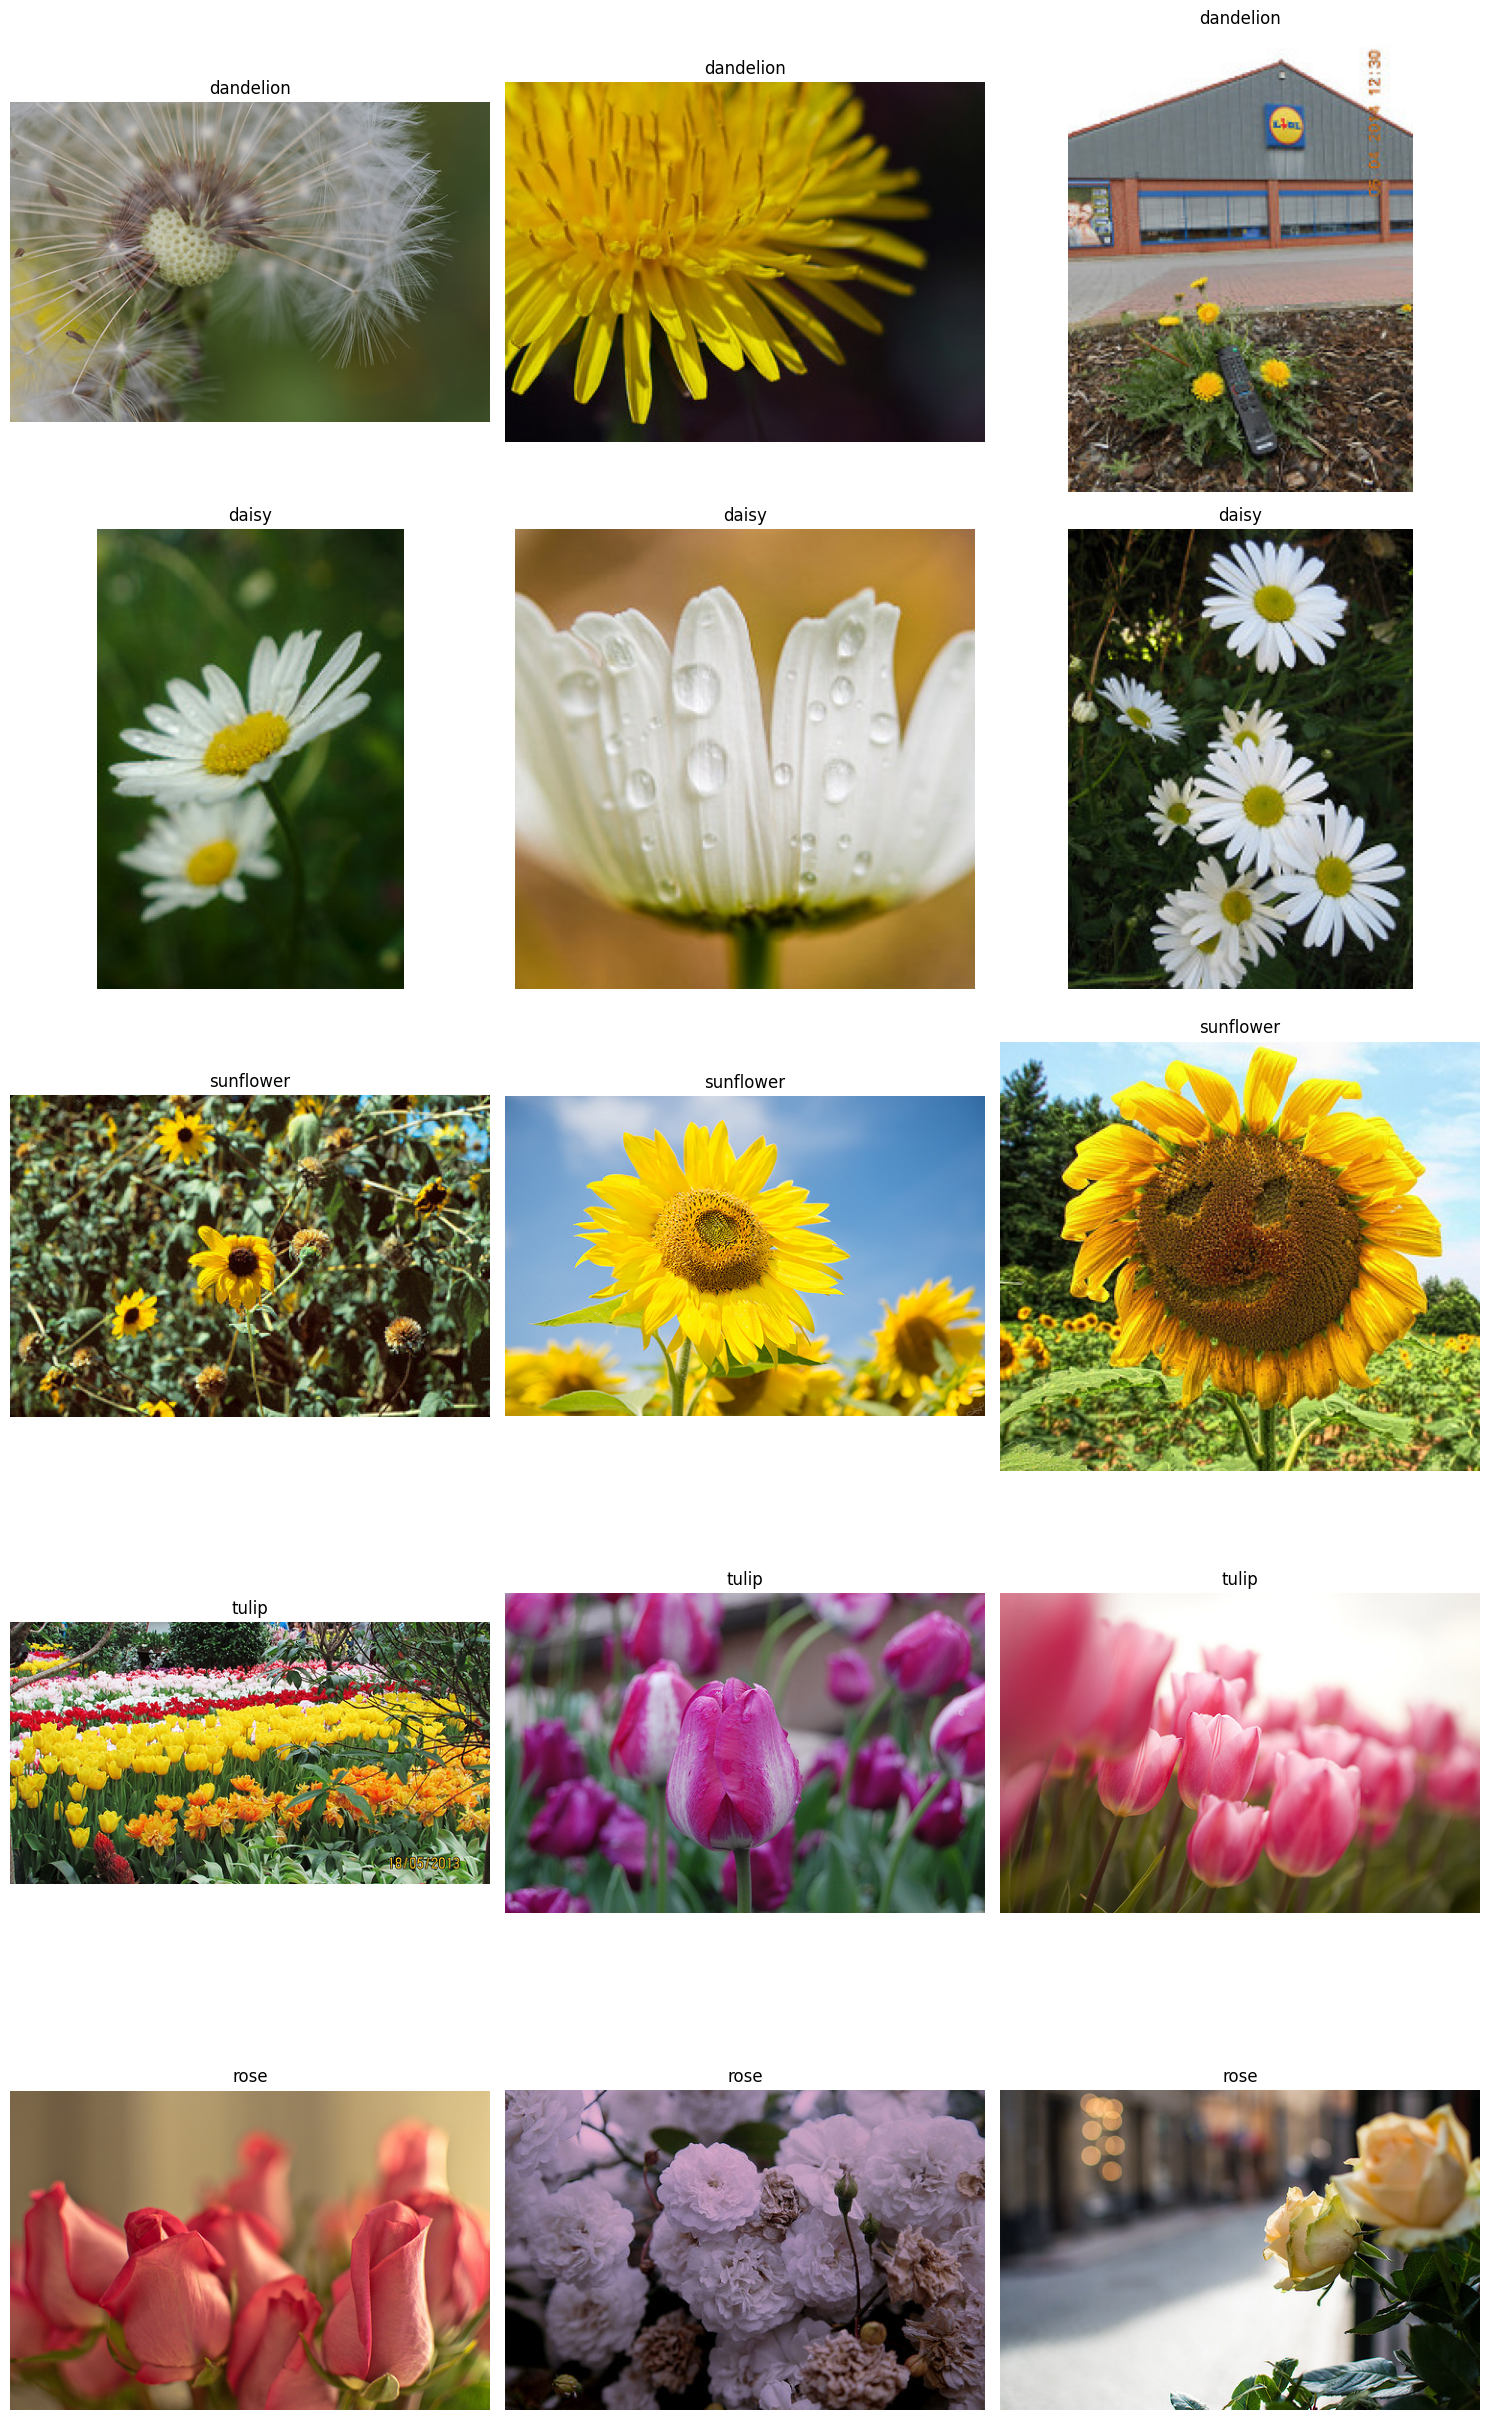

In [30]:
class_names = os.listdir(images)

# Set up a plot with subplots for each class
fig, axs = plt.subplots(len(class_names), 3, figsize=(15, len(class_names) * 5))

for i, cls in enumerate(class_names):
    cls_dir = os.path.join(images, cls)
    image_files = os.listdir(cls_dir)[:3]  # Get the first 3 images
    for j, img_name in enumerate(image_files):
        img_path = os.path.join(cls_dir, img_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(cls)

plt.tight_layout()
plt.show()


### Resize the Images

In [31]:
input_dir = images
output_dir = '/kaggle/working/resized_images'  # Directory to save resized images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define target size
target_size = (128, 128)  # Change to your desired size

# Process and resize images
for cls in os.listdir(input_dir):
    cls_dir = os.path.join(input_dir, cls)
    output_cls_dir = os.path.join(output_dir, cls)
    
    # Create class directory in output directory
    os.makedirs(output_cls_dir, exist_ok=True)
    
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        img = Image.open(img_path)
        
        # Resize image
        img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
        
        # Save resized image
        img_resized.save(os.path.join(output_cls_dir, img_name))


### Split resized_images into training and testing sets

In [32]:
# Define source and destination directories
new_data_dir = '/kaggle/working/resized_images'
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories for each class in train and test directories
for cls in os.listdir(new_data_dir):
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

In [33]:
# Define the proportion of test set
test_size = 0.2  # 20% for test set

# Split images into train and test sets
for cls in os.listdir(new_data_dir):
    cls_dir = os.path.join(new_data_dir, cls)
    image_files = os.listdir(cls_dir)
    
    # Split the data
    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=42)
    
    # Move images to train and test directories
    for img_name in train_files:
        src = os.path.join(cls_dir, img_name)
        dst = os.path.join(train_dir, cls, img_name)
        shutil.copy(src, dst)
    
    for img_name in test_files:
        src = os.path.join(cls_dir, img_name)
        dst = os.path.join(test_dir, cls, img_name)
        shutil.copy(src, dst)

### See the train and test split

In [34]:
# Define directories
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

### Model Architecture

In [35]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),  # Input layer specifying the shape

    # First convolutional block
    layers.Conv2D(32, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    layers.Conv2D(256, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming 5 classes
])

# Display the model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 124, 124, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 25, 25, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,160,837 (8.24 MB)

 Trainable params: 2,160,645 (8.24 MB)

 Non-trainable params: 192 (768.00 B)

### Compile the Model

In [36]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Now train the same Model

In [37]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Can use 'val_accuracy' if preferred
    patience=10,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Train the model with early stopping
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.3355 - loss: 2.0129 - val_accuracy: 0.2968 - val_loss: 1.5630
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4637 - loss: 1.3089 - val_accuracy: 0.2603 - val_loss: 1.5831
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4850 - loss: 1.2596 - val_accuracy: 0.2580 - val_loss: 1.8891
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5080 - loss: 1.1452 - val_accuracy: 0.2854 - val_loss: 1.8299
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5704 - loss: 1.0649 - val_accuracy: 0.3196 - val_loss: 2.3714
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5835 - loss: 1.0557 - val_accuracy: 0.3904 - val_loss: 1.4123
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5987 - loss: 1.0028 - val_accuracy: 0.3630 - val_loss: 1.5732
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6283 - loss: 0.9872 - val_accuracy: 

In [38]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6059 - loss: 0.9571
Test Loss: 0.9417
Test Accuracy: 62.32%


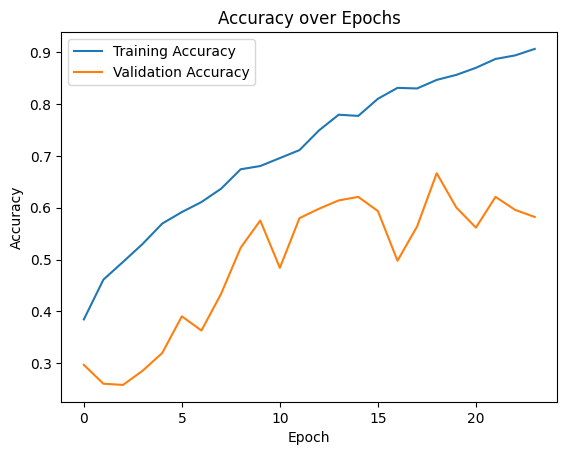

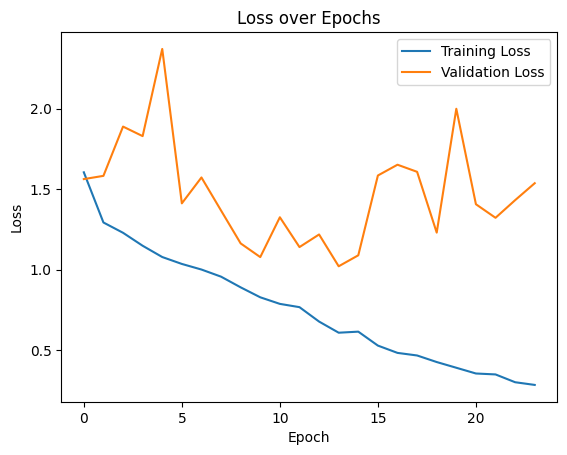

In [39]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()